In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

# 1. Data Prep

We'll load the data into a pandas dataframe. We rename the given variable names with names that are more descriptive.

'mom_iq', 'mom_age_at_childbirth', and 'child_iq' are can reasonably be considered continuous-valued and are hence float-types, while 'mom_high_school' and 'mom_work_status' are boolean and categorical, respectively, which can be respresented by integers.

It's easiest to load everything as floats, although we will want to transform 'mom_work_status' later so that it actually makes sense to use it in a regression model. Also, we are reducing the precision of 'mom_iq' from 12 decimals to 8 decimals, but for a variable whose range is at least 50, there's no need for 12 digits of precision.

In [45]:
variable_dict = {'i': [], 'a': [], 'h': [], 'w': [], 'score': []}

with open('data.txt', 'r') as file:
    next(file)  # skip header line
    for line in file:
        chunks = line.replace('\n', '').replace('\'', '').split('|')  # [line number, variable, value]

        try:
            int(chunks[0]), float(chunks[2])  # check that line number and value are appropriate types
        except ValueError:
            print(f'Value error on line labeled {chunks[0]}. Skipping.')
            continue

        variable_dict[chunks[1]].append(float(chunks[2]))

data = pd.DataFrame(variable_dict, index=list(range(len(variable_dict['i']))))

data = data.rename(columns={
    'i': 'mom_iq',
    'a': 'mom_age_at_childbirth',
    'h': 'mom_high_school',
    'w': 'mom_work_status',
    'score': 'child_iq'
})

data.head()

Value error on line labeled 0xC0. Skipping.


,mom_iq,mom_age_at_childbirth,mom_high_school,mom_work_status,child_iq
0,121.117529,27.0,1.0,4.0,65.0
1,89.361882,25.0,1.0,4.0,98.0
2,115.443165,27.0,1.0,4.0,85.0
3,99.449639,25.0,1.0,3.0,83.0
4,92.745710,27.0,1.0,4.0,115.0


In [46]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mom_iq                 434 non-null    float64
 1   mom_age_at_childbirth  434 non-null    float64
 2   mom_high_school        434 non-null    float64
 3   mom_work_status        434 non-null    float64
 4   child_iq               434 non-null    float64
dtypes: float64(5)
memory usage: 20.3 KB


We don't have to worry about filling any NaNs.

# 2. Data Transformation 

We need to transform 'mom_work_status' because there's no sense in which e.g. status=4 has twice the value of status=2. We'll one-hot encode this variable.

In [50]:
data[['mom_high_school', 'mom_work_status']] = data[['mom_high_school', 'mom_work_status']].astype(int)

data = pd.get_dummies(data, columns=['mom_work_status'], prefix='mom_work_status')
data.head()

,mom_iq,mom_age_at_childbirth,mom_high_school,child_iq,mom_work_status_1,mom_work_status_2,mom_work_status_3,mom_work_status_4
0,121.117529,27.0,1,65.0,0,0,0,1
1,89.361882,25.0,1,98.0,0,0,0,1
2,115.443165,27.0,1,85.0,0,0,0,1
3,99.449639,25.0,1,83.0,0,0,1,0
4,92.745710,27.0,1,115.0,0,0,0,1


I would consider data normalization to be part of this section, but we'll save that for after the EDA because we need to see the variables' distributions before e.g. dropping outliers.

# 3. EDA

Let's visualize the variable distributions:

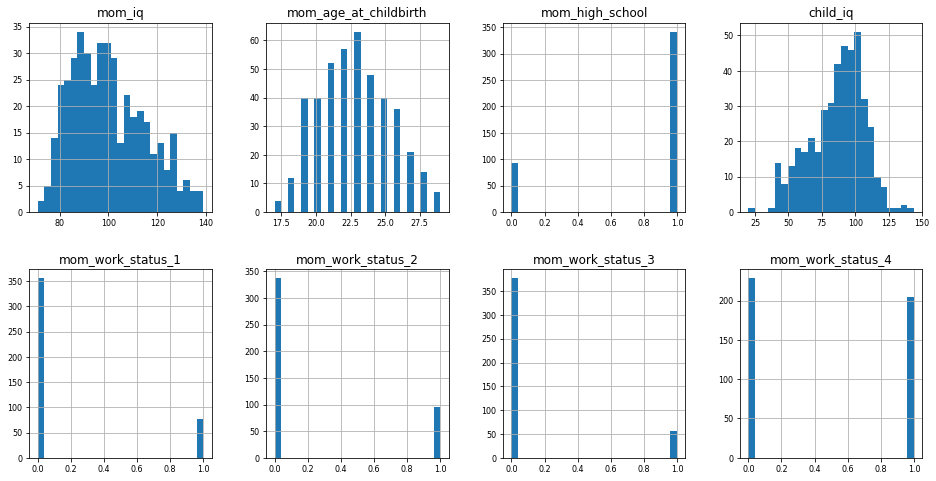

In [63]:
data.hist(figsize=(16, 8), bins=25, layout=(2,4), xlabelsize=8, ylabelsize=8);

The numerical variables are relatively Gaussian-distributed, which justifies using standardization on them. The boolean variables are mostly somewhat imbalanced, which is to be expected after one-hot encoding, but they still each have significant representation.

Now we'll visualize single-variable relationships with the dependent variable.

First with the numerical independent variables:

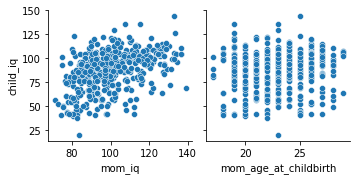

In [69]:
sns.pairplot(
    data=data,
    x_vars=['mom_iq', 'mom_age_at_childbirth'],
    y_vars=['child_iq']
);

And now with the boolean independent variables:

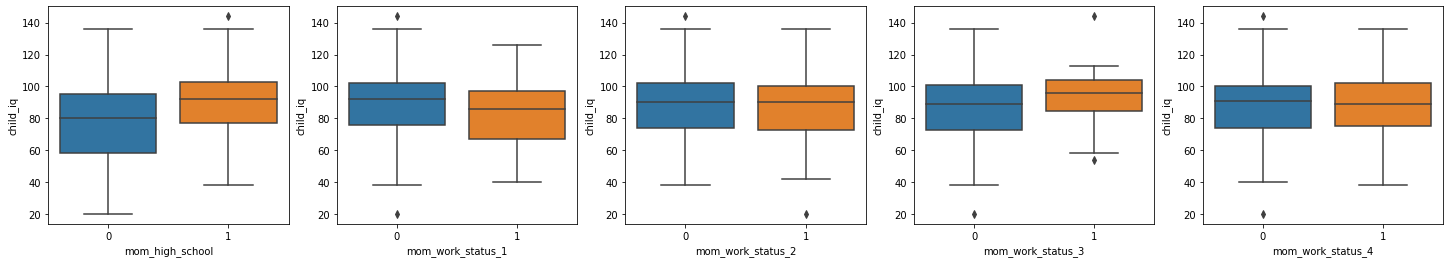

In [90]:
_, axs = plt.subplots(1, 5, figsize=(25,4))
for idx, cat_var in enumerate(['mom_high_school'] + ['mom_work_status_'+str(i) for i in range(1,5)]): 
    sns.boxplot(
        ax=axs[idx],
        data=data,
        x=cat_var, 
        y='child_iq', 
    );

A child_iq of either 20 or 140+ seems to be outlying in several boolean-numerical input-output plots, as well as somewhat qualitatively-outlying in the numerical-numerical input-output plots. Let's drop those two data points. 

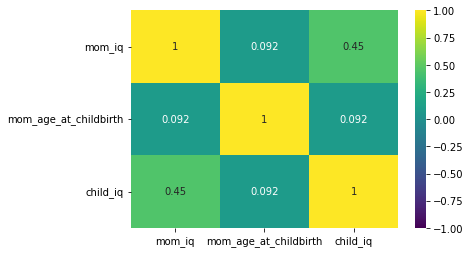

In [95]:
corr = data[['mom_iq', 'mom_age_at_childbirth', 'child_iq']].corr()

sns.heatmap(corr, cmap='viridis', vmax=1.0, vmin=-1.0, annot=True);